## Dados ausentes e status de reconhecimento federal

Considerando que existem features descritivas com elevado valor de dados ausentes, testou-se a relação entre o não-preenchimento de informações pelos municípios e se houve ou não reconhecimento federal.

### Bibliotecas e bases de dados

In [9]:
#Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=2):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Base de dados

object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    decimal=',',
    dtype=dtype)

### Manipulação da base de dados

In [10]:
#criar df só com campos descritivos e status
colunas_descr = ['Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao','PEPL_Descricao','PEPR_Descricao']
df_eventos_descr = df_eventos[colunas_descr]

estilo_tabelas(df_eventos_descr.tail(5))

,Status,DH_Descricao,DM_Descricao,DA_Descricao,PEPL_Descricao,PEPR_Descricao
26253,Reconhecido,A seca tem causado interrupções no fornecimento de água potável para a população dos núcleos urbanos e limitações severas no consumo de água nos domicílios situados na zona rural que precisam aguardar um tempo elevado para que a água acumule em cisterna em volume que seja possível bombear. _x000D_ _x000D_,nan,Redução dos cursos de água e pastagem provocado pela seca.,"Aluguel de 01 caminhão pipa para abastecimento de domicílios rurais, distribuição de 50 caixas água mineral para a população, 380 litros combustível para a frota municipal utilizada nas ações de assistência e distribuição de 200 cestas básicas.","Com a estiagem, houve perdas nos setores da agricultura, pecuária e abastecimento de água principalmente nas comunidades rurais. Houve redução na produção agrícola de 40,43%, perda por mortalidade de animais em torno de 1,0%, redução na produção de carne de 16,7% e redução na produção de leite de 33,3%."
26254,Reconhecido,"Conforme laudo da assistência social, o desastre Tempestade Local/Convectiva - Vendaval atingiu o município em todo o seu território urbano e rural, afetando diretamente 1.180 famílias, aproximadamente 4.716 pessoas, desse total, aproximadamente 30 pessoas ficaram desalojadas. Ainda dentro desse número de famílias 30 famílias foram diretamente afetadas, sendo aproximadamente 120 pessoas encontram-se em vulnerabilidade social. Todos os afetados tiveram danos em suas residências, em telhados, em muitas delas perdendo móveis, roupas e alimentos. Estradas no interior que ficaram sem condições seguras de trafegabilidade e/ou bloqueadas, conforme constatado pela engenharia. A tempestade que atingiu o município afetou as famílias também com a falta de energia elétrica e consequentemente de água, sendo restabelecida em todo o território do município somente no dia 02 de Janeiro.","Conforme laudo da engenharia o evento vendaval causou danos em aproximadamente 30 unidades habitacionais, 01 instalação pública de saúde, uma de ensino e ainda nas estradas rurais do município.",Os danos ambientais recorrem da grande quantidade de lixo produzido pela quebra das telhas de fibrocimento e queda de árvores.,"Conforme laudo da secretaria de administração, o município aportou aproximadamente R$ 6.000,00 em limpeza urbana, recolhimento e destinação do lixo. Ainda conforme laudo da Engenharia os danos/prejuízos nas estradas rurais, instalações públicas de ensino e saúde aproximam-se do valor de R$ 135.000,00.","Conforme laudo da Emater, os prejuízos decorrentes do evento somam-se ao valor de R$ 3.384.500,00 na pecuária."
26255,Reconhecido,"Conforme laudo da assistência social, 20 famílias, 80 pessoas ficaram desalojadas devido destelhamento das suas residências, sendo que três moradias teve todo telhado arrancado, com tesouras e forro. No total foram 276 unidades habitacionais danificadas conforme laudo da engenharia. Ainda conforme laudo da Emater em anexo, houve prejuízos na pecuária que chegam ao valor de R$ 132.000,00.","Conforme laudo da engenharia foram danificadas 276 unidades habitacionais, 07 instalações públicas de ensino sofreram destelhamento devidos aos fortes ventos.",Os danos ambientais recorrem da grande quantidade de lixo produzido pelas quebra das telhas de fibrocimento e quedas de inúmeras árvores.,"Conforme laudo da secretaria de administração, o município de Tenente portela gastou até o momento o valor aproximado de R$ 8.000,00 em abastecimento de água potável as famílias atingidas, R$ 5.500,00 em limpeza urbana recolhimento e destinação do lixo. Somam-se ainda, conforme laudo da engenharia os danos/prejuízos em 7 instalações públicas de ensino valor aproximado de R$ 25.000,00.","Conforme laudo da Emater, o evento vendaval ocasionou danos e prejuízos na pecuária, valor este que aproximam-se de R$ 132.000,00."
26256,Reconhecido,"As pessoas atingidas, tiveram os telhados de suas residências danificados, moveis mo

In [15]:
ausentes = pd.DataFrame({
    '% dados ausentes': df_eventos_descr.isnull().mean() * 100
})

estilo_tabelas(ausentes)


,% dados ausentes
Status,0.00
DH_Descricao,25.14
DM_Descricao,47.61
DA_Descricao,38.77
PEPL_Descricao,31.60
PEPR_Descricao,25.42


### Análise dos dados ausentes nas colunas de descrição

Levantou-se a hipótese de que, uma vez que a análise para o reconhecimento ou não é feita manualmente, solicitações com descrições preenchidas poderiam resultar com mais frequência no status de "Reconhecimento".

In [19]:
#criar um dataset com instancias que possuem pelo menos um valor isnull
null_data = df_eventos_descr.isnull()
df_descr_missing = df_eventos_descr[null_data.any(axis=1)]

df_descr_missing['Total_Missing'] = df_descr_missing[colunas_descr].isnull().sum(axis=1)

In [24]:
prop_df = df_descr_missing.groupby(['Total_Missing', 'Status'])['Status'].count().unstack()
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

estilo_tabelas(prop_df)

Status,Não reconhecido,Reconhecido
Total_Missing,,
1,0.09,0.91
2,0.17,0.83
3,0.30,0.70
4,0.07,0.93
5,0.05,0.95


#### Campos de descrição preenchidos vs status de reconhecimento

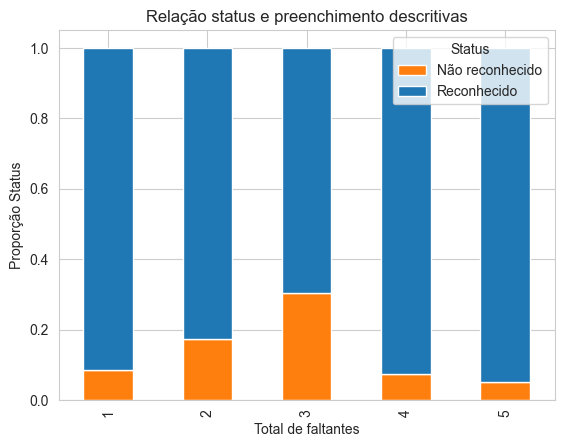

In [25]:
prop_df.plot(kind='bar', color= ["#ff7f0e","#1f77b4"], stacked=True)
plt.xlabel('Total de faltantes')
plt.ylabel('Proporção Status')
plt.title('Relação status e preenchimento descritivas')
plt.legend(title='Status')
plt.rcParams['figure.figsize'] = (7, 3)
plt.show()

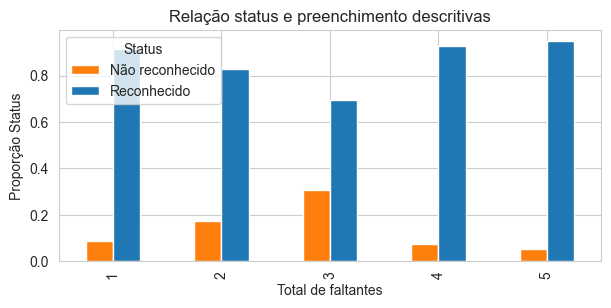

In [26]:
prop_df.plot(kind='bar', color = ["#ff7f0e","#1f77b4"])
plt.xlabel('Total de faltantes')
plt.ylabel('Proporção Status')
plt.title('Relação status e preenchimento descritivas')
plt.legend(title='Status')
plt.rcParams['figure.figsize'] = (7, 3)
plt.show()

#### Testes de correlação para variáveis categóricas

In [27]:
##TESTES DE CORRELAÇÃO PARA VARIÁVEIS CATEGÓRICAS

## Chi-quadrado
from scipy.stats import chi2_contingency

tabela_cont1 = pd.crosstab(df_descr_missing['Total_Missing'], df_descr_missing['Status'])
chi2, p, dof, expected = chi2_contingency(tabela_cont1)

print("Chi-quadrado:", chi2)
print("P-valor:", p)

###Cramer's V
contingency_table1 = pd.crosstab(df_descr_missing['Total_Missing'], df_descr_missing['Status'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
## Calculate Cramer's V
n = contingency_table1.sum().sum()  # Total number of observations
phi2 = chi2 / n
k = min(contingency_table1.shape) - 1  # Number of categories in the smaller variable
cramers_v = np.sqrt(phi2 / k)
print("Cramer's V:", cramers_v)

Chi-quadrado: 591.0525262674172
P-valor: 1.3385599544407019e-126
Cramer's V: 0.18870007661588079


#### Descrição de danos materiais vs status de reconhecimento

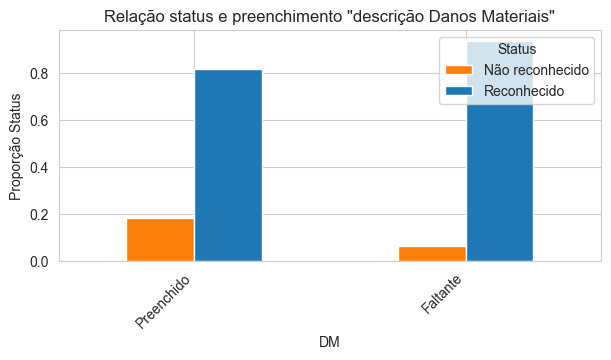

In [32]:
#Para Danos Materiais

df_descr_missing['dm_isnull'] = df_descr_missing['DM_Descricao'].isnull()

prop_df_dm = df_descr_missing.groupby(['dm_isnull', 'Status'])['Status'].count().unstack()

prop_df_dm = prop_df_dm.div(prop_df_dm.sum(axis=1), axis=0)

# Plotar 'DM_Descricao' as the x-axis
prop_df_dm.plot(kind='bar', color= ["#ff7f0e","#1f77b4"], stacked=False)
plt.xlabel('DM')
plt.ylabel('Proporção Status')
plt.title('Relação status e preenchimento "descrição Danos Materiais"')
plt.legend(title='Status')

plt.xticks(rotation=45, ha='right')  # Rotate for better readability if needed
ax = plt.gca()
ax.xaxis.get_major_formatter()._usetex = False # Disable mathtext for tick labels
# plt.show()
x_labels = ['Preenchido', 'Faltante']  # Define your desired labels here
plt.xticks(prop_df_dm.index, x_labels, rotation=45, ha='right')
plt.show()

#### Descrição de danos humanos vs status de reconhecimento

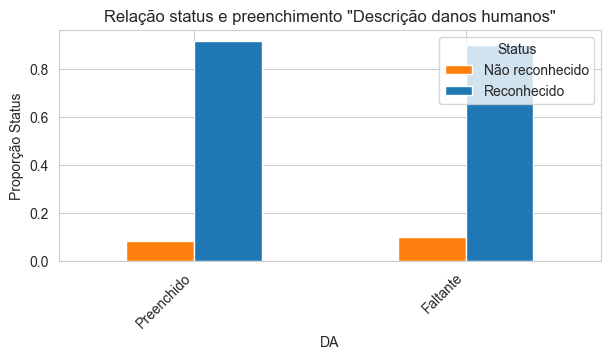

In [33]:
#Para DA
df_descr_missing['da_isnull'] = df_descr_missing['DA_Descricao'].isnull()

#print(df_descr_missing.head())
prop_df_da = df_descr_missing.groupby(['da_isnull', 'Status'])['Status'].count().unstack()

prop_df_da = prop_df_da.div(prop_df_da.sum(axis=1), axis=0)

prop_df_da.plot(kind='bar', color= ["#ff7f0e","#1f77b4"], stacked=False)
plt.xlabel('DA')
plt.ylabel('Proporção Status')
plt.title('Relação status e preenchimento "Descrição danos humanos"')
plt.legend(title='Status')

plt.xticks(rotation=45, ha='right')  # Rotate for better readability if needed
ax = plt.gca()
ax.xaxis.get_major_formatter()._usetex = False # Disable mathtext for tick labels
# plt.show()
x_labels = ['Preenchido', 'Faltante']  # Define your desired labels here
plt.xticks(prop_df_dm.index, x_labels, rotation=45, ha='right')
plt.show()

#### Descrição de prejuízos econômicos públicos vs status de reconhecimento

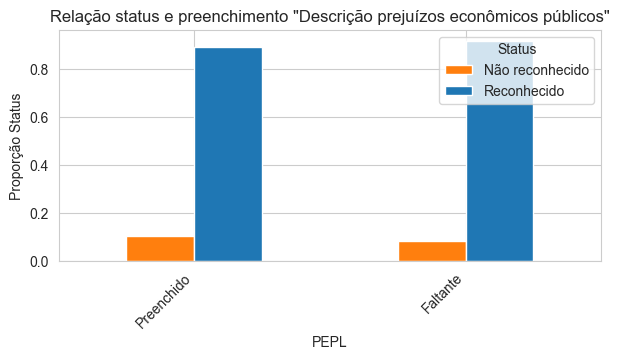

In [35]:
#Para PEPL
df_descr_missing['pepl_isnull'] = df_descr_missing['PEPL_Descricao'].isnull()

#print(df_descr_missing.head())
prop_df_pepl = df_descr_missing.groupby(['pepl_isnull', 'Status'])['Status'].count().unstack()

prop_df_pepl = prop_df_pepl.div(prop_df_pepl.sum(axis=1), axis=0)

prop_df_pepl.plot(kind='bar', color= ["#ff7f0e","#1f77b4"], stacked=False)
plt.xlabel('PEPL')
plt.ylabel('Proporção Status')
plt.title('Relação status e preenchimento "Descrição prejuízos econômicos públicos"')
plt.legend(title='Status')

plt.xticks(rotation=45, ha='right')  # Rotate for better readability if needed
ax = plt.gca()
ax.xaxis.get_major_formatter()._usetex = False # Disable mathtext for tick labels
# plt.show()
x_labels = ['Preenchido', 'Faltante']  # Define your desired labels here
plt.xticks(prop_df_dm.index, x_labels, rotation=45, ha='right')
plt.show()

#### Descrição de prejuízos econômicos privados vs status de reconhecimento

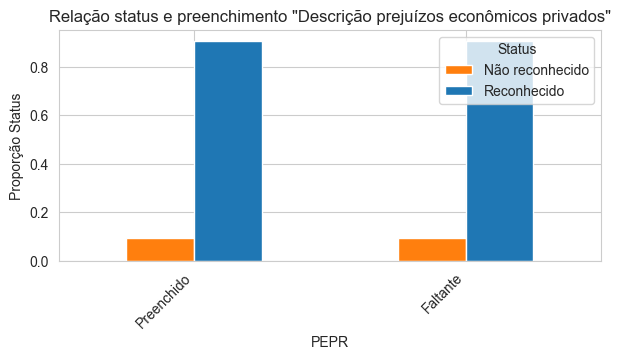

In [36]:
#PEPR
df_descr_missing['pepr_isnull'] = df_descr_missing['PEPR_Descricao'].isnull()

#print(df_descr_missing.head())
prop_df_pepr = df_descr_missing.groupby(['pepr_isnull', 'Status'])['Status'].count().unstack()

prop_df_pepr = prop_df_pepr.div(prop_df_pepr.sum(axis=1), axis=0)

prop_df_pepr.plot(kind='bar', color= ["#ff7f0e","#1f77b4"], stacked=False)
plt.xlabel('PEPR')
plt.ylabel('Proporção Status')
plt.title('Relação status e preenchimento "Descrição prejuízos econômicos privados"')
plt.legend(title='Status')

plt.xticks(rotation=45, ha='right')  # Rotate for better readability if needed
ax = plt.gca()
ax.xaxis.get_major_formatter()._usetex = False # Disable mathtext for tick labels
# plt.show()
x_labels = ['Preenchido', 'Faltante']  # Define your desired labels here
plt.xticks(prop_df_dm.index, x_labels, rotation=45, ha='right')
plt.show()

#### Descrição de danos humanos vs status de reconhecimento

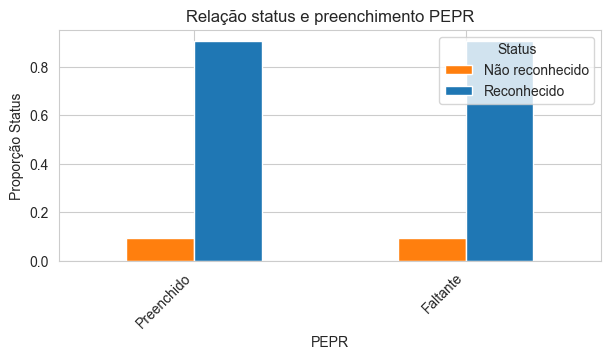

In [37]:
#DH
df_descr_missing['dh_isnull'] = df_descr_missing['DH_Descricao'].isnull()

#print(df_descr_missing.head())
prop_df_dh = df_descr_missing.groupby(['dh_isnull', 'Status'])['Status'].count().unstack()

prop_df_dh = prop_df_dh.div(prop_df_dh.sum(axis=1), axis=0)

prop_df_pepr.plot(kind='bar', color= ["#ff7f0e","#1f77b4"], stacked=False)
plt.xlabel('PEPR')
plt.ylabel('Proporção Status')
plt.title('Relação status e preenchimento PEPR')
plt.legend(title='Status')

plt.xticks(rotation=45, ha='right')  # Rotate for better readability if needed
ax = plt.gca()
ax.xaxis.get_major_formatter()._usetex = False # Disable mathtext for tick labels
# plt.show()
x_labels = ['Preenchido', 'Faltante']  # Define your desired labels here
plt.xticks(prop_df_dm.index, x_labels, rotation=45, ha='right')
plt.show()
